# Basic sentyment analysis with python and nltk

In [8]:
for n in range (1, 30): 
    print('\n', n)
    print('Weird') if (n%2!=0 or (n>5 and n<21)) else print('not weird')



 1
Weird

 2
not weird

 3
Weird

 4
not weird

 5
Weird

 6
Weird

 7
Weird

 8
Weird

 9
Weird

 10
Weird

 11
Weird

 12
Weird

 13
Weird

 14
Weird

 15
Weird

 16
Weird

 17
Weird

 18
Weird

 19
Weird

 20
Weird

 21
Weird

 22
not weird

 23
Weird

 24
not weird

 25
Weird

 26
not weird

 27
Weird

 28
not weird

 29
Weird


## Apertura dei dati
Useremo il file [Reviews.csv](https://www.kaggle.com/snap/amazon-fine-food-reviews) dal set di dati Amazon Fine Food Reviews di Kaggle per eseguire l'analisi.


In [1]:
import pandas as pd
df = pd.read_csv('../data/Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Possiamo vedere che il dataframe contiene alcune informazioni su prodotti, utenti e recensioni.

I dati che utilizzeremo maggiormente per questa analisi sono "Summary", "Text" e "Score".

    "Text" - Questa variabile contiene le informazioni complete sulla recensione del prodotto.
    "Summary" - Questo è un riassunto dell'intera recensione.
    "Score" - La valutazione del prodotto fornita dal cliente.

### Undersampling

Prendiamo un subset dei dati per velocizzare i test

In [2]:
df_full=df

In [3]:
df=df.sample(50000)

## Analisi esplorativa dei dati
Diamo un'occhiata alla variabile "Score" per vedere se la maggioranza delle valutazioni dei clienti sono positive o negative.


In [4]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px


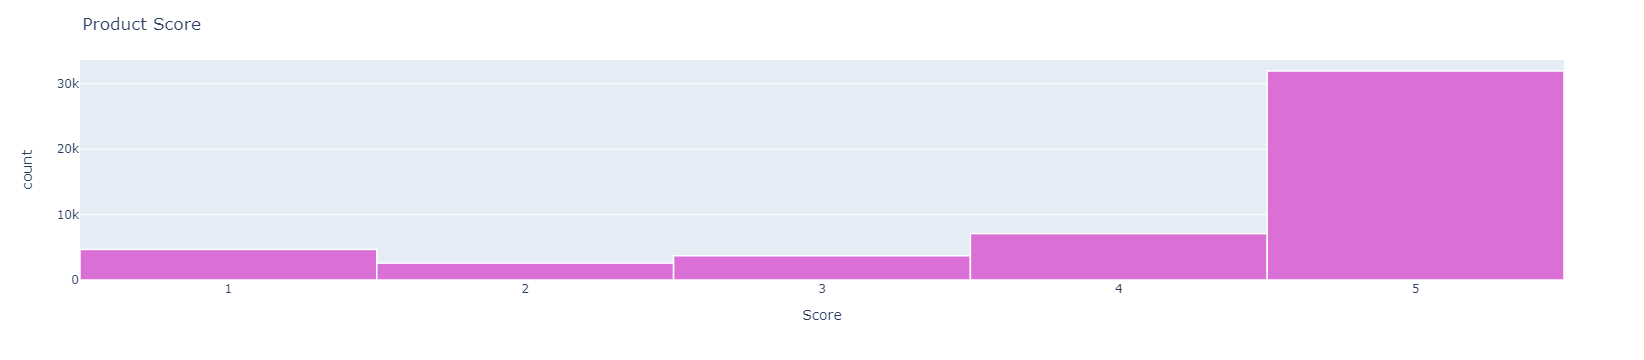

In [5]:
# Product Scores

fig = px.histogram(df, x="Score")
fig.update_traces(marker_color="Orchid ",marker_line_color='white',
                  marker_line_width=1.5)
fig.update_layout(title_text='Product Score')
fig.show()

Da qui, possiamo vedere che la maggior parte della valutazione dei clienti è positiva.
Ora, possiamo creare alcune wordclouds per vedere le parole più frequentemente usate nelle recensioni.

In [6]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud 


In [7]:
#nltk.download('stopwords') #per rimuovere le parole come preposizioni e interiezioni

In [8]:
STOPWORDS=stopwords.words('english')

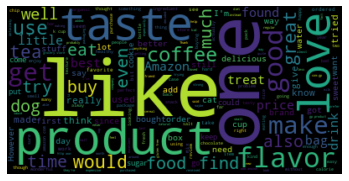

In [9]:
# Crea una lista di stopword:
stopwords = set(STOPWORDS)
stopwords.update(["br", "href"])
textt = " ".join(review for review in df.Text)
wordcloud = WordCloud(stopwords=stopwords).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

In [10]:
# assegna le recensioni con punteggio > 3 come sentimento positivo
# punteggio < 3 sentimento negativo
# rimuovi il punteggio = 3
df = df[df['Score'] != 3]
df['sentiment'] = df['Score'].apply(lambda rating : +1 if rating > 3 else -1)

In [11]:
# dividere df - sentimento positivo e negativo:
positive = df[df['sentiment'] == 1]
negative = df[df['sentiment'] == -1]

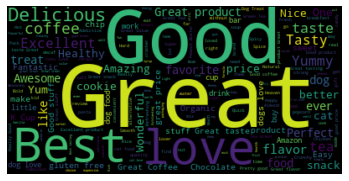

In [12]:
stopwords = set(STOPWORDS)
stopwords.update(["br", "href"]) 
pos = " ".join(review for review in positive.Summary)
wordcloud2 = WordCloud(stopwords=stopwords).generate(pos)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

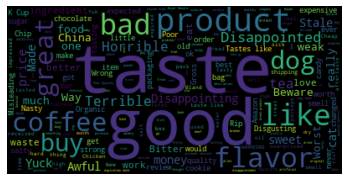

In [13]:
neg = " ".join(str(review) for review in negative.Summary)
wordcloud3 = WordCloud(stopwords=stopwords).generate(neg)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud33.png')
plt.show()

Come visto sopra, la nuvola di parole del sentimento positivo era piena di parole positive, come "love", "best" e "good".
La nuvola di parole del sentimento negativo era piena di parole per lo più negative, come "terrible" e "waste".
Le parole "good" e "great" sono apparse nella nuvola di parole del sentimento negativo, nonostante siano parole positive. Questo probabilmente perché erano usate in un contesto negativo, come "not good". Questo ci permette di visualizzare subito un limite deglli approcci "bag-of-word".
Infine, possiamo dare un'occhiata alla distribuzione delle recensioni con sentiment in tutto il dataset:


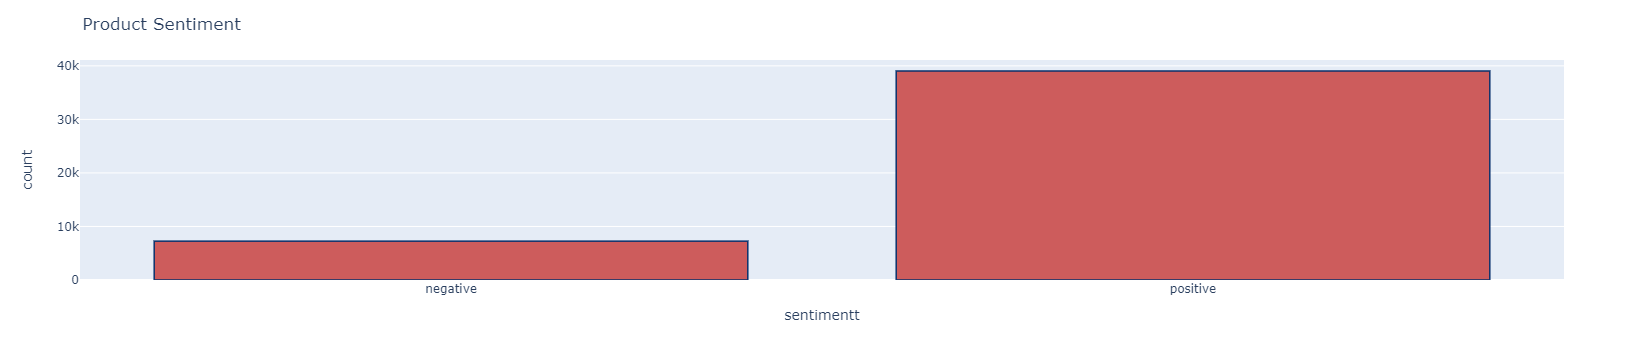

In [14]:
df['sentimentt'] = df['sentiment'].replace({-1 : 'negative'})
df['sentimentt'] = df['sentimentt'].replace({1 : 'positive'})
fig = px.histogram(df, x="sentimentt")
fig.update_traces(marker_color="indianred",marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5)
fig.update_layout(title_text='Product Sentiment')
fig.show()

## Costruire un modello base
Finalmente possiamo costruire il modello di sentiment analysis!
Questo modello prenderà le recensioni come input. Poi farà una previsione sul fatto che la recensione sia positiva o negativa.
Questo è un compito di classificazione, quindi addestreremo un semplice modello di regressione logistica per farlo.


### Pulizia dei dati
Useremo i dati delle summary per fare delle previsioni. Per prima cosa, dobbiamo rimuovere tutta la punteggiatura dai dati.

In [15]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"'))
    return final
df['Text'] = df['Text'].apply(remove_punctuation)
df = df.dropna(subset=['Summary'])
df['Summary'] = df['Summary'].apply(remove_punctuation)

### Dividere il Dataframe
Il nuovo dataframe dovrebbe avere solo due colonne - "Summary" (i dati del testo della recensione), e "sentiment" (la variabile obiettivo).

In [16]:
dfNew = df[['Summary','sentiment']]
dfNew.head()

,Summary,sentiment
90217,Dissapointed with this product,-1
42353,Wonderful oils- essential for a cook,1
483977,These are great,1
339605,Junk Food labeled as healthy food,-1
209085,Extremely hard to set,-1


Ora divideremo il frame di dati in insiemi di allenamento e di test. L'80% dei dati sarà usato per l'addestramento e il 20% per il test.

In [17]:
import numpy as np

In [18]:
# random split train and test data
index = df.index
df['random_number'] = np.random.randn(len(index))
train = df[df['random_number'] <= 0.8]
test = df[df['random_number'] > 0.8]

### Creare un sacchetto di parole
Successivamente, useremo un count vectorizer dalla libreria Scikit-learn.
Questo trasformerà il testo nel nostro data frame in un modello di bag of words, che conterrà una matrice sparsa di interi. Il numero di occorrenze di ogni parola sarà contato e stampato.
Avremo bisogno di convertire il testo in un modello di bag-of-words poiché l'algoritmo di regressione logistica non può capire il testo.


In [19]:
# count vectorizer:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train['Summary'])
test_matrix = vectorizer.transform(test['Summary'])

### Importazione di regressione logistica

In [20]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

### Dividere le variabili target e indipendenti

In [21]:
X_train = train_matrix
X_test = test_matrix
y_train = train['sentiment']
y_test = test['sentiment']

### Training del modello sui dati 

In [22]:
lr.fit(X_train,y_train)

C:\Users\e.ferri\Anaconda3\envs\nlp\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

### Fare previsioni

In [23]:
predictions = lr.predict(X_test)

### Test
Possiamo testare la precisione del nostro modello:

In [24]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)

array([[ 897,  212],
       [ 683, 8160]], dtype=int64)

In [25]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

          -1       0.57      0.81      0.67      1109
           1       0.97      0.92      0.95      8843

    accuracy                           0.91      9952
   macro avg       0.77      0.87      0.81      9952
weighted avg       0.93      0.91      0.92      9952



## Modelli diversi

In [26]:
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [27]:
models = []
models.append(('LR', LogisticRegression(solver='sag', max_iter=1000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('GB',  GradientBoostingClassifier()))

In [28]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
     kfold = model_selection.KFold(n_splits=5)
     cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
     results.append(cv_results)
     names.append(name)
     msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
     print(msg)

LR: 0.908010 (0.004012)
KNN: 0.890757 (0.009637)
CART: 0.892876 (0.010874)
SVM: 0.914807 (0.003377)
ADA: 0.881759 (0.005525)
GB: 0.886575 (0.005082)


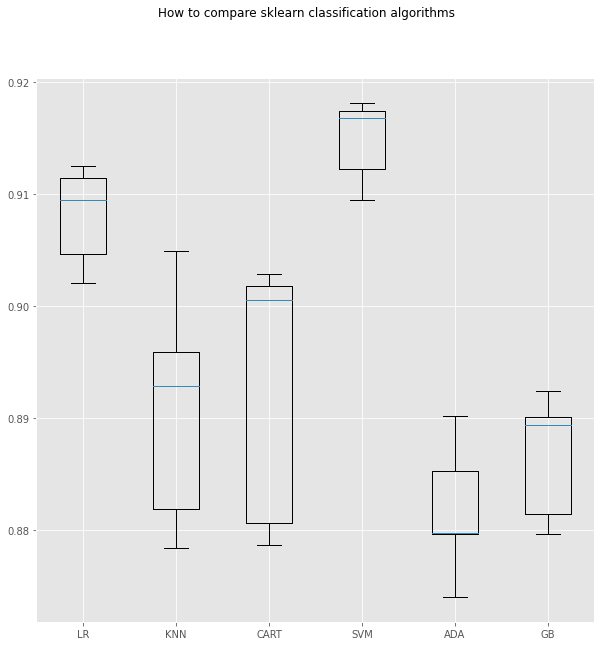

In [29]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('How to compare sklearn classification algorithms')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()